#Question 3#: Transition from Recurrence to Self-Attention
**Objective**: To analyze the empirical and conceptual shift from recurrent neural networks to self-attention-driven architectures using the Multi30k dataset

### 1.1 Environment Setup & Dataset Loading
Initialize the environment with random seeds for reproducibility, configure GPU/CPU device, load DistilBERT tokenizers for German (encoder) and English (decoder), and load the Multi30k dataset for German-English translation task.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import math
import time
import random
import numpy as np
from datasets import load_dataset
import subprocess
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

from transformers import DistilBertTokenizer, DistilBertModel

# Set random seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# --- 1. Distinct Tokenizers ---
print("Loading Tokenizers...")
# Encoder (German): German BERT
tokenizer_src = DistilBertTokenizer.from_pretrained('distilbert-base-german-cased')
# Decoder (English):  English BERT 
tokenizer_trg = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
PAD_IDX = tokenizer_src.pad_token_id
VOCAB_SIZE_TRG = tokenizer_trg.vocab_size

print(f"Vocab Size: {VOCAB_SIZE_TRG}, Pad Index: {PAD_IDX}")

# Load Multi30k dataset
DATASET_ID = "bentrevett/multi30k"
print(f"Loading '{DATASET_ID}'...")
try:
    dataset = load_dataset(DATASET_ID)
    dataset['valid'] = dataset.pop('validation')
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")

# Global stats container
global_stats = {}
%matplotlib inline

Device: cuda
Loading Tokenizers...
Vocab Size: 30522, Pad Index: 0
Loading 'bentrevett/multi30k'...
Vocab Size: 30522, Pad Index: 0
Loading 'bentrevett/multi30k'...
Dataset loaded successfully.
Dataset loaded successfully.


### 1.2 Pre-computed BERT Feature Extraction
Extract German sentence embeddings using DistilBERT model before training to save GPU memory and accelerate training. This approach stores 768-dimensional vectors for source sentences and token IDs for target sentences, eliminating the need to run BERT during training.

In [ ]:
# --- CELL 2:DATA LOADING (PRE-COMPUTED BERT) ---

import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from transformers import DistilBertTokenizer, DistilBertModel
from datasets import load_dataset
from tqdm import tqdm

# 1. Tokenizer and Model
print("Loading DistilBERT for feature extraction...")
tokenizer_src = DistilBertTokenizer.from_pretrained('distilbert-base-german-cased')
tokenizer_trg = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-german-cased').to(device)
bert_model.eval() 

# Constants
PAD_IDX = tokenizer_src.pad_token_id
VOCAB_SIZE_TRG = tokenizer_trg.vocab_size
BATCH_SIZE = 64

# 2. Helper: Pre-compute Embeddings Function
def extract_features(split_name, data):
    """
    Veri setindeki tüm Almanca cümleleri BERT'ten geçirip
    vektörlerini (embeddings) ve İngilizce ID'leri kaydeder.
    """
    print(f"Extracting features for {split_name}...")
    src_list = []
    trg_list = []

    # Process in batches (Inference mode)
    temp_loader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=False)

    with torch.no_grad():
        for batch in tqdm(temp_loader):
            # German Texts -> BERT -> Vectors
            de_raw = batch['de']
            inputs = tokenizer_src(de_raw, return_tensors='pt', padding=True, truncation=True, max_length=64).to(device)
            outputs = bert_model(**inputs)

            # Get last layer vectors (Batch, Seq, 768)
            
            embeddings = outputs.last_hidden_state.cpu()

            # Append each sentence according to the mask (Remove paddings)
            for i, mask in enumerate(inputs['attention_mask'].cpu()):
                valid_len = mask.sum().item()
                src_list.append(embeddings[i, :valid_len, :].clone()) # Only take the filled part

            # English Texts -> ID List
            en_raw = batch['en']
            trg_encoded = tokenizer_trg(en_raw, truncation=True, max_length=64)['input_ids']
            for t in trg_encoded:
                trg_list.append(torch.tensor(t, dtype=torch.long))

    return src_list, trg_list

# 3. Load Dataset and Extract Features
dataset = load_dataset("bentrevett/multi30k")
dataset['valid'] = dataset.pop('validation')

# Pre-compute features for the entire dataset 
train_src, train_trg = extract_features('Train', dataset['train'])
valid_src, valid_trg = extract_features('Valid', dataset['valid'])
test_src, test_trg = extract_features('Test', dataset['test'])


class VectorDataset(Dataset):
    def __init__(self, src_vectors, trg_tokens):
        self.src = src_vectors
        self.trg = trg_tokens

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        return self.src[idx], self.trg[idx]

# 5. Collate Function (To Pad Vectors and Tokens)
def collate_fn_vectors(batch):
    src_vecs, trg_tokens = zip(*batch)

    # Source: Already vectors (seq, 768). Padding value should be a zero vector.
    src_pad = pad_sequence(src_vecs, padding_value=0, batch_first=True)

    # Target: Token ID (seq). Padding value PAD_IDX.
    trg_pad = pad_sequence(trg_tokens, padding_value=PAD_IDX, batch_first=True)

    # No need to create mask, 0 places are padding but we can still return mask
    src_mask = (src_pad.abs().sum(dim=-1) > 0).long()

    return {
        'src': src_pad.to(device),      # [Batch, Seq, 768] 
        'trg': trg_pad.to(device),      # [Batch, Seq] -> ID
        'src_mask': src_mask.to(device) # [Batch, Seq]
    }

# 6. Final DataLoaders
train_loader = DataLoader(VectorDataset(train_src, train_trg), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_vectors)
valid_loader = DataLoader(VectorDataset(valid_src, valid_trg), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_vectors)
test_loader  = DataLoader(VectorDataset(test_src, test_trg),  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_vectors)

del bert_model
torch.cuda.empty_cache()

print(f"🚀 Pre-computed DataLoaders Ready. BERT removed from memory.")

Loading DistilBERT for feature extraction...
Extracting features for Train...
Extracting features for Train...


100%|██████████| 454/454 [00:42<00:00, 10.71it/s]


Extracting features for Valid...


100%|██████████| 16/16 [00:01<00:00, 10.39it/s]


Extracting features for Test...


100%|██████████| 16/16 [00:01<00:00, 11.50it/s]

🚀 Pre-computed DataLoaders Ready. BERT removed from memory.


### 2.1 RNN Seq2Seq Architecture (Bahdanau Attention)
Define the RNN-based encoder-decoder architecture with **Bahdanau (Additive) Attention** mechanism. The encoder uses a bidirectional GRU to process pre-computed BERT embeddings, while the decoder employs attention-weighted context vectors for translation generation.

In [3]:
# --- 3. MODEL ARCHITECTURE ---

import torch
import torch.nn as nn
import torch.nn.functional as F
import random

class DistilBertEmbedding(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.projection = nn.Linear(768, output_dim)

    def forward(self, x, mask):
        return self.projection(x)

# --- Q2 ENCODER ---
class Encoder(nn.Module):
    def __init__(self, hid_dim, n_layers, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = DistilBertEmbedding(hid_dim)
        self.rnn = nn.GRU(hid_dim, hid_dim, n_layers, bidirectional=True, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        embedded = self.dropout(self.embedding(src, src_mask))
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden

# --- Q2 ATTENTION  ---
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask):
        src_len = encoder_outputs.shape[1]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)

        if mask is not None:
            attention = attention.masked_fill(mask == 0, -1e10)

        return F.softmax(attention, dim=1)

# --- Q2 DECODER ---
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.attention = Attention(enc_hid_dim, dec_hid_dim)
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim, n_layers, batch_first=True, dropout=dropout)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs, mask):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden[-1], encoder_outputs, mask).unsqueeze(1)
        weighted = torch.bmm(a, encoder_outputs)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=2).squeeze(1))
        return prediction, hidden

# --- Q2 SEQ2SEQ ---
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.fc_hidden = nn.Linear(encoder.hid_dim * 2, decoder.rnn.hidden_size)

    def forward(self, src, trg, src_mask, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        outputs = torch.zeros(batch_size, trg_len, self.decoder.output_dim).to(self.device)

        encoder_outputs, encoder_hidden = self.encoder(src, src_mask)

        hidden_forward = encoder_hidden[-2]
        hidden_backward = encoder_hidden[-1]
        hidden_cat = torch.cat((hidden_forward, hidden_backward), dim=1)
        decoder_hidden = torch.tanh(self.fc_hidden(hidden_cat)).unsqueeze(0).repeat(self.decoder.rnn.num_layers, 1, 1)

        input = trg[:, 0]
        for t in range(1, trg_len):
            output, decoder_hidden = self.decoder(input, decoder_hidden, encoder_outputs, src_mask)
            outputs[:, t] = output
            input = trg[:, t] if random.random() < teacher_forcing_ratio else output.argmax(1)

        return outputs

print("RNN Architecture (Fixed Attention Mask) Defined.")

RNN Architecture (Fixed Attention Mask) Defined.


### 2.2 Transformer Architecture
Implement the Transformer model with **Multi-Head Self-Attention** mechanism. The architecture includes positional encoding for sequence order, BERT projection layer for source embeddings, and standard encoder-decoder transformer blocks with causal masking for autoregressive generation.

In [ ]:
# --- 4. TRANSFORMER ARCHITECTURE ---

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, output_dim, emb_dim, nhead, hid_dim, n_layers, dropout, device):
        super().__init__()
        self.device = device
        self.emb_dim = emb_dim

        # 1. Encoder Projection (BERT Vectors -> Model Dim)
        self.bert_proj = nn.Linear(768, emb_dim)

        # 2. Decoder Embedding
        self.trg_embedding = nn.Embedding(output_dim, emb_dim)

        # 3. Components
        self.pos_encoder = PositionalEncoding(emb_dim, dropout)

        self.transformer = nn.Transformer(
            d_model=emb_dim,
            nhead=nhead,
            num_encoder_layers=n_layers,
            num_decoder_layers=n_layers,
            dim_feedforward=hid_dim,
            dropout=dropout,
            batch_first=True
        )

        self.fc_out = nn.Linear(emb_dim, output_dim)

    def make_trg_mask(self, trg):
        length = trg.shape[1]
        mask = torch.triu(torch.ones(length, length) * float('-inf'), diagonal=1)
        return mask.to(self.device)

    def forward(self, src, trg, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # src: [Batch, Seq, 768] (Vector)
        # trg: [Batch, Seq] (Token ID)

        # --- Projection & Positional Encoding ---
        src_emb = self.pos_encoder(self.bert_proj(src))
        trg_emb = self.pos_encoder(self.trg_embedding(trg) * math.sqrt(self.emb_dim))

        # --- Transformer Forward Pass ---
        # Masking provided externally (from Training Loop)
        output = self.transformer(
            src=src_emb,
            tgt=trg_emb,
            tgt_mask=tgt_mask, # Decoder causal mask
            src_key_padding_mask=src_pad_mask, # Encoder padding
            tgt_key_padding_mask=tgt_pad_mask, # Decoder padding
            memory_key_padding_mask=src_pad_mask # Cross-Attention padding
        )

        return self.fc_out(output)

print("TransformerModel (Mask-Ready) Defined.")

TransformerModel (Mask-Ready) Defined.


### 3.1 Training Utilities & Custom Masking
Define training helper functions including custom mask generation for Transformer (causal mask, padding masks), training/evaluation loops with gradient clipping, and epoch timing utilities. Both RNN and Transformer models share the same training infrastructure for fair comparison.

In [ ]:
# --- 5. TRAINING UTILITIES ---

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

# --- MASK GENERATION HELPER ---
def batch_mask_factory(src_vectors, trg_tokens, device):
    """
    Generates all necessary masks for the Transformer in one go.
    Logic: Positions where vectors are all zeros are padding.
    """
    # 1. Target Look-Ahead Mask (Causal)
    sz = trg_tokens.size(1)
    tgt_mask = torch.triu(torch.ones(sz, sz, device=device) * float('-inf'), diagonal=1)

    # 2. Source Padding Mask (Vector Analysis)
    # If the absolute sum of all elements of a word vector is 0, it is padding.
    # src_vectors: [Batch, Seq, 768] -> [Batch, Seq]
    src_pad_mask = (src_vectors.abs().sum(dim=-1) == 0)

    # 3. Target Padding Mask (ID Analysis)
    tgt_pad_mask = (trg_tokens == PAD_IDX)

    return tgt_mask, src_pad_mask,tgt_pad_mask

# --- TRAINING LOOP ---
def train_epoch(model, iterator, optimizer, criterion, clip, model_type='transformer', scheduler=None):
    model.train()
    epoch_loss = 0

    for batch in tqdm(iterator, desc="Training", leave=False):
        # Pre-computed data
        src = batch['src'].to(device)
        trg = batch['trg'].to(device)

        optimizer.zero_grad()

        if model_type == "transformer":
            # Input (SOS -> End-1) and Output (Start+1 -> EOS) separation
            trg_input = trg[:, :-1]
            trg_output = trg[:, 1:]

            # Generate Masks
            t_mask, s_pad, t_pad = batch_mask_factory(src, trg_input, device)

            # Give to Model
            output = model(src, trg_input, tgt_mask=t_mask, src_pad_mask=s_pad, tgt_pad_mask=t_pad)

            # Calculate Loss
            output = output.reshape(-1, output.shape[-1])
            trg_output = trg_output.reshape(-1)
            loss = criterion(output, trg_output)

        else:
            # RNN Logic
            output = model(src, trg, src_mask=None)
            output = output[:, 1:].reshape(-1, output.shape[-1])
            trg = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        if scheduler:
            scheduler.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# Evaluate function
def evaluate_epoch(model, iterator, criterion, model_type='transformer'):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in iterator:
            src = batch['src'].to(device)
            trg = batch['trg'].to(device)

            if model_type == "transformer":
                trg_input = trg[:, :-1]
                trg_output = trg[:, 1:]

                # Same masks are needed for validation as well
                t_mask, s_pad, t_pad = batch_mask_factory(src, trg_input, device)

                output = model(src, trg_input, tgt_mask=t_mask, src_pad_mask=s_pad, tgt_pad_mask=t_pad)

                loss = criterion(output.reshape(-1, output.shape[-1]), trg_output.reshape(-1))
            else:
                output = model(src, trg, src_mask=None, teacher_forcing_ratio=0.0)
                loss = criterion(output[:, 1:].reshape(-1, output.shape[-1]), trg[:, 1:].reshape(-1))

            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# Run Training Wrapper
def run_training(model, train_loader, valid_loader, optimizer, criterion, n_epochs, model_name, clip=1.0, scheduler=None):
    print(f"\n--- Starting Training: {model_name} ---")
    history = {'train_loss': [], 'valid_loss': [], 'train_ppl': [], 'valid_ppl': []}
    model_type = "transformer" if "Transformer" in str(type(model)) else "rnn"

    for epoch in range(n_epochs):
        start_time = time.time()
        train_loss = train_epoch(model, train_loader, optimizer, criterion, clip, model_type, scheduler)
        valid_loss = evaluate_epoch(model, valid_loader, criterion, model_type)
        end_time = time.time()

        train_ppl = math.exp(train_loss) if train_loss < 100 else float('inf')
        valid_ppl = math.exp(valid_loss) if valid_loss < 100 else float('inf')

        history['train_loss'].append(train_loss)
        history['valid_loss'].append(valid_loss)
        history['valid_ppl'].append(valid_ppl)

        mins, secs = epoch_time(start_time, end_time)
        print(f'Epoch: {epoch+1:02} | Time: {mins}m {secs}s | Train Loss: {train_loss:.3f} | Val PPL: {valid_ppl:.2f}')

    return history

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

print("Training functions with Custom Masking ready.")

Training functions with Custom Masking ready.


### 4.1 Model Training & Comparative Visualization
Train both RNN (Seq2Seq + Bahdanau) and Transformer models with comparable hyperparameters. Visualize training stability through loss curves, perplexity trends, generalization gap analysis, and stability metrics to evaluate the transition from recurrence to self-attention.

1. Initializing RNN Model (Seq2Seq + Bahdanau + Bridge)...
RNN Parameters: 42,778,938

--- Starting Training: RNN_Model ---
RNN Parameters: 42,778,938

--- Starting Training: RNN_Model ---


Epoch: 01 | Time: 7m 11s | Train Loss: 4.919 | Val PPL: 143.69


Epoch: 02 | Time: 7m 13s | Train Loss: 3.883 | Val PPL: 63.62


Epoch: 03 | Time: 7m 9s | Train Loss: 3.059 | Val PPL: 43.05


Epoch: 04 | Time: 7m 20s | Train Loss: 2.611 | Val PPL: 36.49


Epoch: 05 | Time: 7m 11s | Train Loss: 2.310 | Val PPL: 31.45

2. Initializing Transformer Model (DistilBERT Integration)...
Transformer Parameters: 18,491,450

--- Starting Training: Transformer_Model ---
Transformer Parameters: 18,491,450

--- Starting Training: Transformer_Model ---


Training:   0%|          | 0/454 [00:00<?, ?it/s]c:\Users\ali19\anaconda3\Lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Training:   0%|          | 1/454 [00:00<01:14,  6.06it/s]c:\Users\ali19\anaconda3\Lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
c:\Users\ali19\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(
c:\Users\ali19\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:502: UserWarning: The PyTorch API of nested tensors is 

Epoch: 01 | Time: 1m 12s | Train Loss: 4.058 | Val PPL: 14.29


Epoch: 02 | Time: 1m 8s | Train Loss: 2.350 | Val PPL: 7.33


Epoch: 03 | Time: 1m 7s | Train Loss: 1.820 | Val PPL: 5.63


Epoch: 04 | Time: 1m 10s | Train Loss: 1.518 | Val PPL: 5.07


Epoch: 05 | Time: 1m 11s | Train Loss: 1.310 | Val PPL: 4.69

Training Complete. Plotting comparative results...


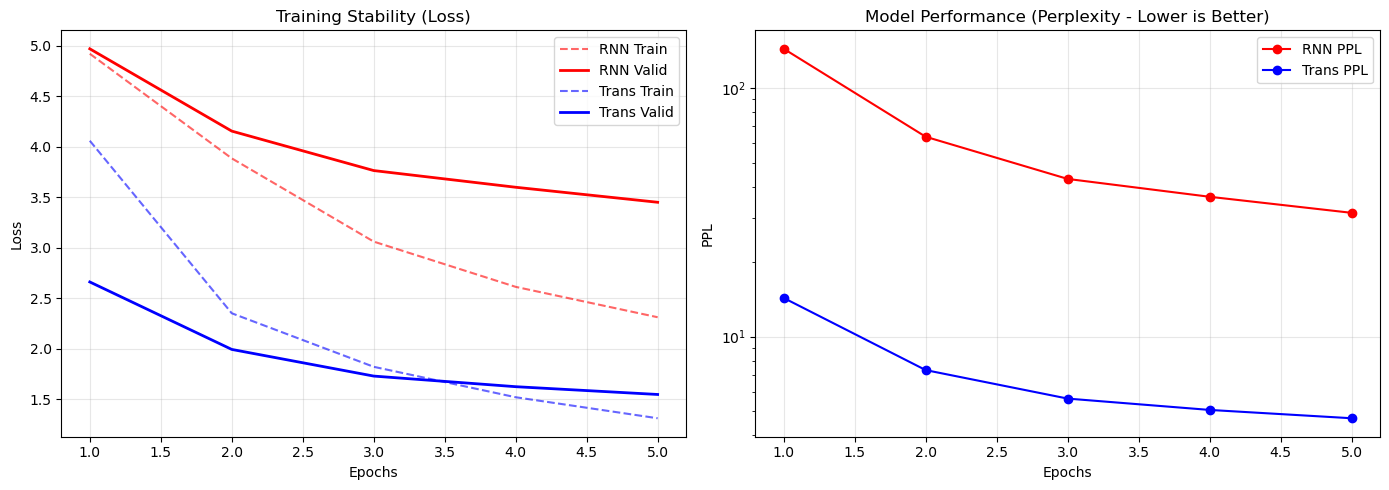

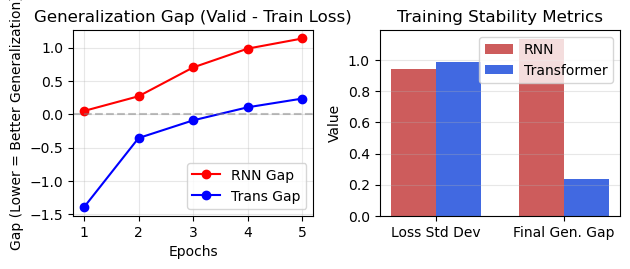


📊 TRAINING STABILITY REPORT
Metric                    | RNN          | Transformer 
------------------------------------------------------------
Final Train Loss          | 2.3104       | 1.3104      
Final Valid Loss          | 3.4484       | 1.5458      
Final Valid PPL           | 31.45        | 4.69        
Loss Std Dev (Stability)  | 0.9441       | 0.9872      
Final Gen. Gap            | 1.1381       | 0.2354      
------------------------------------------------------------


In [ ]:
# --- 6. MODEL INITIALIZATION, TRAINING & VISUALIZATION ---

import matplotlib.pyplot as plt

# --- A. Hyperparameters ---
HID_DIM = 256
ENC_LAYERS = 2
DEC_LAYERS = 2
ENC_HEADS = 8
TRANS_FF_DIM = 512
RNN_DROPOUT = 0.1
TRANS_DROPOUT = 0.1
N_EPOCHS = 5
LEARNING_RATE_RNN = 0.0005
LEARNING_RATE_TRANS = 0.0005

# --- B. RNN MODEL TRAINING (Q2 Architecture + DistilBERT) ---
print("="*40)
print("1. Initializing RNN Model (Seq2Seq + Bahdanau + Bridge)...")
# Initialize Model (With Optimized Target Vocab Size)
enc = Encoder(HID_DIM, ENC_LAYERS, RNN_DROPOUT)
dec = Decoder(VOCAB_SIZE_TRG, HID_DIM, HID_DIM, HID_DIM, DEC_LAYERS, RNN_DROPOUT)
model_rnn = Seq2Seq(enc, dec, device).to(device)
# Parameter Count
print(f"RNN Parameters: {sum(p.numel() for p in model_rnn.parameters() if p.requires_grad):,}")
# Optimizer & Loss
optimizer_rnn = optim.Adam(model_rnn.parameters(), lr=LEARNING_RATE_RNN)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Start Training
rnn_history = run_training(model_rnn, train_loader, valid_loader,
                            optimizer_rnn, criterion, N_EPOCHS, "RNN_Model", clip=1.0)


# --- C. TRANSFORMER MODEL TRAINING (DistilBERT + Masks) ---
print("\n" + "="*40)
print("2. Initializing Transformer Model (DistilBERT Integration)...")

# Initialize Model
model_trans = TransformerModel(
    output_dim=VOCAB_SIZE_TRG,
    emb_dim=HID_DIM,
    nhead=ENC_HEADS,
    hid_dim=TRANS_FF_DIM,
    n_layers=ENC_LAYERS,
    dropout=TRANS_DROPOUT,
    device=device
).to(device)

# Reset Weights (Xavier Init)
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
model_trans.apply(initialize_weights)

# Parameter Count
print(f"Transformer Parameters: {sum(p.numel() for p in model_trans.parameters() if p.requires_grad):,}")

# Optimizer
optimizer_trans = optim.Adam(model_trans.parameters(), lr=LEARNING_RATE_TRANS)

# Start Training
trans_history = run_training(model_trans, train_loader, valid_loader,
                             optimizer_trans, criterion, N_EPOCHS, "Transformer_Model", clip=1.0)


# --- D. RESULTS VISUALIZATION --
def plot_results(rnn_hist, trans_hist):
    epochs = range(1, len(rnn_hist['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    # 1. Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, rnn_hist['train_loss'], 'r--', alpha=0.6, label='RNN Train')
    plt.plot(epochs, rnn_hist['valid_loss'], 'r-', linewidth=2, label='RNN Valid')
    plt.plot(epochs, trans_hist['train_loss'], 'b--', alpha=0.6, label='Trans Train')
    plt.plot(epochs, trans_hist['valid_loss'], 'b-', linewidth=2, label='Trans Valid')
    plt.title('Training Stability (Loss)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig("training_stability_loss_comparison.png")

    # 2. Perplexity Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, rnn_hist['valid_ppl'], 'r-o', label='RNN PPL')
    plt.plot(epochs, trans_hist['valid_ppl'], 'b-o', label='Trans PPL')
    plt.title('Model Performance (Perplexity - Lower is Better)')
    plt.xlabel('Epochs')
    plt.ylabel('PPL')
    plt.legend()
    plt.yscale('log') 
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    plt.savefig("training_stability_comparison.png")
    
    # 3.Generalization Gap (Overfitting Indicator)
    plt.subplot(2, 2, 3)
    rnn_gap = [v - t for v, t in zip(rnn_hist['valid_loss'], rnn_hist['train_loss'])]
    trans_gap = [v - t for v, t in zip(trans_hist['valid_loss'], trans_hist['train_loss'])]
    plt.plot(epochs, rnn_gap, 'r-o', label='RNN Gap')
    plt.plot(epochs, trans_gap, 'b-o', label='Trans Gap')
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    plt.title('Generalization Gap (Valid - Train Loss)')
    plt.xlabel('Epochs')
    plt.ylabel('Gap (Lower = Better Generalization)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig("generalization_gap_comparison.png")
    
    # 4.Stability Metrics Bar Chart
    plt.subplot(2, 2, 4)
    rnn_var = np.std(rnn_hist['train_loss'])
    trans_var = np.std(trans_hist['train_loss'])
    rnn_final_gap = rnn_hist['valid_loss'][-1] - rnn_hist['train_loss'][-1]
    trans_final_gap = trans_hist['valid_loss'][-1] - trans_hist['train_loss'][-1]
    
    x = np.arange(2)
    width = 0.35
    plt.bar(x - width/2, [rnn_var, rnn_final_gap], width, label='RNN', color='indianred')
    plt.bar(x + width/2, [trans_var, trans_final_gap], width, label='Transformer', color='royalblue')
    plt.xticks(x, ['Loss Std Dev', 'Final Gen. Gap'])
    plt.title('Training Stability Metrics')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()
    plt.savefig("stability_metrics_comparison.png")


    # --- NUMERICAL SUMMARY  ---
    print("\n" + "="*60)
    print("📊 TRAINING STABILITY REPORT")
    print("="*60)
    print(f"{'Metric':<25} | {'RNN':<12} | {'Transformer':<12}")
    print("-"*60)
    print(f"{'Final Train Loss':<25} | {rnn_hist['train_loss'][-1]:<12.4f} | {trans_hist['train_loss'][-1]:<12.4f}")
    print(f"{'Final Valid Loss':<25} | {rnn_hist['valid_loss'][-1]:<12.4f} | {trans_hist['valid_loss'][-1]:<12.4f}")
    print(f"{'Final Valid PPL':<25} | {rnn_hist['valid_ppl'][-1]:<12.2f} | {trans_hist['valid_ppl'][-1]:<12.2f}")
    print(f"{'Loss Std Dev (Stability)':<25} | {rnn_var:<12.4f} | {trans_var:<12.4f}")
    print(f"{'Final Gen. Gap':<25} | {rnn_final_gap:<12.4f} | {trans_final_gap:<12.4f}")
    print("-"*60)

print("\nTraining Complete. Plotting comparative results...")
plot_results(rnn_history, trans_history)

### 4.2 Model Checkpointing
Save trained RNN and Transformer model weights to disk for later evaluation and inference. Checkpoints include model state, optimizer state, and final validation loss for reproducibility.

In [7]:
# --- 7.SAVE MODELS ---
import os

RNN_SAVE_PATH = 'rnn_model_final.pt'
TRANS_SAVE_PATH = 'transformer_model_final.pt'

print(f"Saving models to disk...")

# 1. Save RNN Model
torch.save({
    'epoch': N_EPOCHS,
    'model_state_dict': model_rnn.state_dict(),
    'optimizer_state_dict': optimizer_rnn.state_dict(),
    'loss': rnn_history['valid_loss'][-1],
}, RNN_SAVE_PATH)
print(f"✅ RNN Model saved: {RNN_SAVE_PATH}")

# 2. Save Transformer Model
torch.save({
    'epoch': N_EPOCHS,
    'model_state_dict': model_trans.state_dict(),
    'optimizer_state_dict': optimizer_trans.state_dict(),
    'loss': trans_history['valid_loss'][-1],
}, TRANS_SAVE_PATH)
print(f"✅ Transformer Model saved: {TRANS_SAVE_PATH}")

Saving models to disk...
✅ RNN Model saved: rnn_model_final.pt
✅ RNN Model saved: rnn_model_final.pt
✅ Transformer Model saved: transformer_model_final.pt
✅ Transformer Model saved: transformer_model_final.pt


### 5.1 Ablation Study: Layer & Head Variations
Conduct ablation experiments by varying the number of Transformer layers (1, 4) and attention heads (4, 8) to analyze the impact on model performance. This study reveals degradation or robustness trends as architectural complexity changes.

🚀 Starting Ablation Study with 2 configurations...

--- Training Config: Light (Layers=1, Heads=4) ---

--- Starting Training: Light ---


Training:   0%|          | 0/454 [00:00<?, ?it/s]c:\Users\ali19\anaconda3\Lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Training:   0%|          | 1/454 [00:00<01:16,  5.88it/s]c:\Users\ali19\anaconda3\Lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
                                                           

Epoch: 01 | Time: 0m 57s | Train Loss: 3.955 | Val PPL: 12.30


Epoch: 02 | Time: 0m 55s | Train Loss: 2.253 | Val PPL: 6.93


Epoch: 03 | Time: 0m 57s | Train Loss: 1.766 | Val PPL: 5.57


Epoch: 04 | Time: 0m 56s | Train Loss: 1.491 | Val PPL: 4.99


Epoch: 05 | Time: 0m 57s | Train Loss: 1.304 | Val PPL: 4.78
✅ Model saved to: ablation_models\transformer_light.pt
--- Training Config: Deep (Layers=4, Heads=8) ---

--- Starting Training: Deep ---

--- Starting Training: Deep ---


Epoch: 01 | Time: 4m 2s | Train Loss: 4.627 | Val PPL: 39.54


Epoch: 02 | Time: 4m 4s | Train Loss: 3.400 | Val PPL: 23.55


Epoch: 03 | Time: 4m 2s | Train Loss: 2.842 | Val PPL: 13.14


Epoch: 04 | Time: 4m 7s | Train Loss: 2.279 | Val PPL: 8.47


Epoch: 05 | Time: 4m 8s | Train Loss: 1.900 | Val PPL: 6.70
✅ Model saved to: ablation_models\transformer_deep.pt


<Figure size 640x480 with 0 Axes>

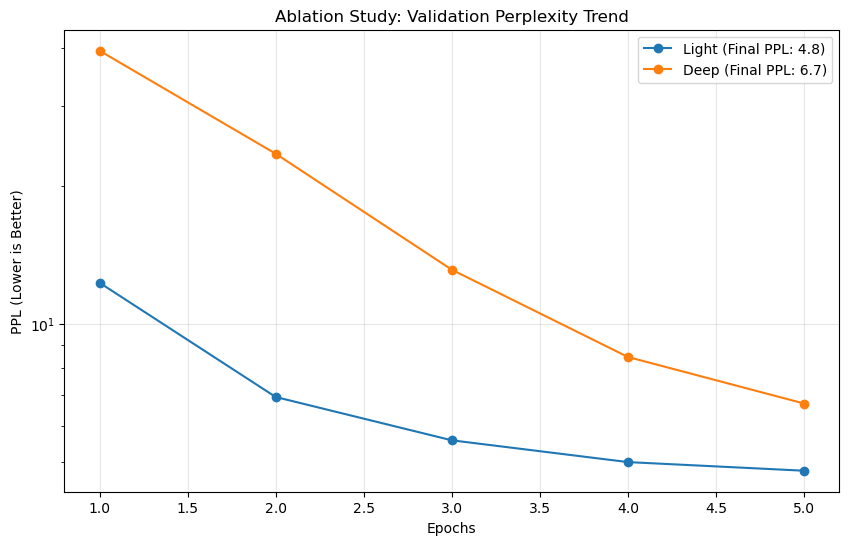

In [8]:
# --- 8. ABLATION STUDY: TRAINING & SAVING CHECKPOINTS ---

import os

# Directory to save model checkpoints
SAVE_DIR = 'ablation_models'
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# Configurations to test (layers, heads)

ablation_configs = [
    {"name": "Light", "layers": 1, "heads": 4},  
    {"name": "Deep",  "layers": 4, "heads": 8}   
]

results = {}
ABLATION_EPOCHS = 5  

print(f"🚀 Starting Ablation Study with {len(ablation_configs)} configurations...\n")

for config in ablation_configs:
    name = config["name"]
    layers = config["layers"]
    heads = config["heads"]
    save_path = os.path.join(SAVE_DIR, f"transformer_{name.lower()}.pt")

    print(f"--- Training Config: {name} (Layers={layers}, Heads={heads}) ---")

    # 1. Initialize Model (Fresh start for every config)
    model_abl = TransformerModel(
        output_dim=VOCAB_SIZE_TRG,
        emb_dim=HID_DIM,
        nhead=heads,           # Variable parameter
        hid_dim=TRANS_FF_DIM,
        n_layers=layers,       # Variable parameter
        dropout=TRANS_DROPOUT,
        device=device
    ).to(device)

    # Reset Weights (Xavier Init)
    model_abl.apply(initialize_weights)

    # Initialize Optimizer
    optimizer_abl = optim.Adam(model_abl.parameters(), lr=LEARNING_RATE_TRANS)

    # 2. Run Training Loop
    history = run_training(
        model_abl,
        train_loader,
        valid_loader,
        optimizer_abl,
        criterion,
        ABLATION_EPOCHS,
        name,
        clip=1.0
    )

    # 3. Save Checkpoint (.pt file)
    torch.save({
        'config': config,
        'model_state_dict': model_abl.state_dict(),
        'valid_loss': history['valid_loss'][-1],
        'valid_ppl': history['valid_ppl'][-1]
    }, save_path)

    print(f"✅ Model saved to: {save_path}")

    # Store history for plotting
    results[name] = history

# --- PLOTTING VALIDATION TRENDS ---
plt.figure(figsize=(10, 6))
for name, hist in results.items():
    epochs = range(1, len(hist['valid_ppl']) + 1)
    final_ppl = hist['valid_ppl'][-1]
    plt.plot(epochs, hist['valid_ppl'], marker='o', label=f"{name} (Final PPL: {final_ppl:.1f})")

plt.title('Ablation Study: Validation Perplexity Trend')
plt.xlabel('Epochs')
plt.ylabel('PPL (Lower is Better)')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()
plt.savefig("ablation_study_validation_ppl.png")

### 6.1 Final Evaluation: BLEU, ROUGE & Efficiency Metrics
Comprehensive evaluation of all models (RNN, Transformer variants) on the test set. Metrics include **BLEU** (translation quality), **ROUGE-L** (longest common subsequence), **inference time**, **GPU memory usage**, and **parameter count** for complete performance and efficiency comparison.

Note: you may need to restart the kernel to use updated packages.
Model           | BLEU     | ROUGE-L  | Time (s)   | Mem (MB)   | Params    
--------------------------------------------------------------------------------
Model           | BLEU     | ROUGE-L  | Time (s)   | Mem (MB)   | Params    
--------------------------------------------------------------------------------


C:\Users\ali19\AppData\Local\Temp\ipykernel_16188\3802921857.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)
        

RNN             | 30.72     | 64.15     | 36.92s      | 2000.3MB     | 42.8M


Trans-Light     | 38.52     | 70.51     | 36.17s      | 1612.4MB     | 17.2M


Trans-Base      | 39.22     | 70.98     | 55.14s      | 1765.2MB     | 18.5M


Trans-Deep      | 30.94     | 63.64     | 92.85s      | 1644.2MB     | 21.1M


C:\Users\ali19\AppData\Local\Temp\ipykernel_16188\3802921857.py:203: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(names, rotation=15)
C:\Users\ali19\AppData\Local\Temp\ipykernel_16188\3802921857.py:216: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(names, rotation=15)


✅ Grafik kaydedildi: final_evaluation_metrics.png


<Figure size 640x480 with 0 Axes>

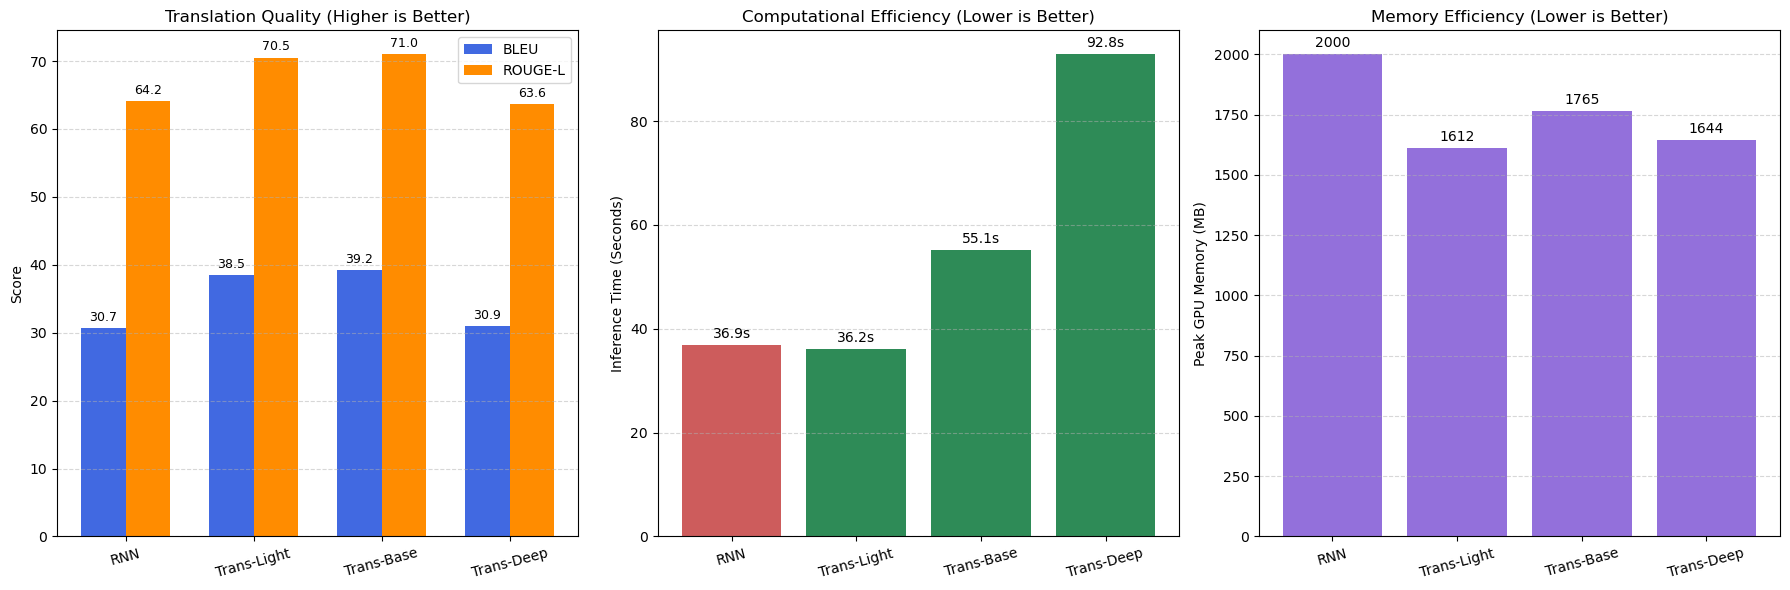


📊 FINAL EVALUATION SUMMARY
Model           | BLEU     | ROUGE-L    | Time (s)   | Memory (MB) 
----------------------------------------------------------------------
RNN             | 30.72    | 64.15      | 36.92      | 2000.3      
Trans-Light     | 38.52    | 70.51      | 36.17      | 1612.4      
Trans-Base      | 39.22    | 70.98      | 55.14      | 1765.2      
Trans-Deep      | 30.94    | 63.64      | 92.85      | 1644.2      
----------------------------------------------------------------------


In [ ]:
# --- 9. GRAND FINAL EVALUATION: METRICS + EFFICIENCY ---
import sacrebleu
from rouge_score import rouge_scorer
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import os
import math
import time

# --- A. Helper functions (GREEDY DECODE) ---
def greedy_decode_vector(model, src_vector, max_len=50):
    model.eval()
    device = src_vector.device
    src_key_padding_mask = (src_vector.abs().sum(dim=-1) == 0)

    with torch.no_grad():
        src_emb = model.pos_encoder(model.bert_proj(src_vector))
        memory = model.transformer.encoder(src_emb, src_key_padding_mask=src_key_padding_mask)

    trg_input = torch.tensor([[101]], device=device)

    for _ in range(max_len):
        tgt_mask = model.make_trg_mask(trg_input)
        tgt_padding_mask = (trg_input == PAD_IDX)

        with torch.no_grad():
            trg_emb = model.pos_encoder(model.trg_embedding(trg_input) * math.sqrt(model.emb_dim))
            out = model.transformer.decoder(
                trg_emb, memory,
                tgt_mask=tgt_mask,
                tgt_key_padding_mask=tgt_padding_mask,
                memory_key_padding_mask=src_key_padding_mask
            )
            logits = model.fc_out(out[:, -1, :])
            next_token = logits.argmax(dim=-1).unsqueeze(1)

        trg_input = torch.cat([trg_input, next_token], dim=1)
        if next_token.item() == 102: break

    return trg_input

# --- B. EVALUATION ENGINE (METRICS + TIME + MEMORY) ---
def evaluate_all_checkpoints(test_loader):
    checkpoints = {
        "RNN":          ("rnn_model_final.pt", None, None),
        "Trans-Light":  ("ablation_models/transformer_light.pt", 1, 4),
        "Trans-Base":   ("transformer_model_final.pt", 2, 8),
        "Trans-Deep":   ("ablation_models/transformer_deep.pt", 4, 8)
    }

    results = {}

    print(f"{'Model':<15} | {'BLEU':<8} | {'ROUGE-L':<8} | {'Time (s)':<10} | {'Mem (MB)':<10} | {'Params':<10}")
    print("-" * 80)

    for name, (path, layers, heads) in checkpoints.items():
        if not os.path.exists(path):
            print(f"⚠️ {name} dosyası bulunamadı, atlanıyor.")
            continue

        # 1. Build the Model
        if name == "RNN":
            enc = Encoder(HID_DIM, ENC_LAYERS, RNN_DROPOUT)
            dec = Decoder(VOCAB_SIZE_TRG, HID_DIM, HID_DIM, HID_DIM, DEC_LAYERS, RNN_DROPOUT)
            model = Seq2Seq(enc, dec, device).to(device)
        else:
            model = TransformerModel(
                output_dim=VOCAB_SIZE_TRG,
                emb_dim=HID_DIM,
                nhead=heads,
                hid_dim=TRANS_FF_DIM,
                n_layers=layers,
                dropout=TRANS_DROPOUT,
                device=device
            ).to(device)

        # 2. Load Weights 
        try:
            checkpoint = torch.load(path, map_location=device)
            state_dict = checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint

            new_state_dict = {}
            for k, v in state_dict.items():
                if 'bert_proj.0' in k:
                    new_key = k.replace('bert_proj.0', 'bert_proj')
                    new_state_dict[new_key] = v
                else:
                    new_state_dict[k] = v

            model.load_state_dict(new_state_dict)
        except Exception as e:
            print(f"❌ {name} yüklenirken hata: {e}")
            continue

        model.eval()
        params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        # --- 3. PREDICTION AND EFFICIENCY MEASUREMENT ---
        preds, refs = [], []

        # Reset GPU Memory and Time
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()

        start_time = time.time()

        with torch.no_grad():
            for batch in tqdm(test_loader, desc=name, leave=False):
                src = batch['src']
                trg = batch['trg']

                for i in range(src.shape[0]):
                    src_single = src[i].unsqueeze(0)

                    if "RNN" in name:
                        out = model(src_single, trg[i].unsqueeze(0), src_mask=None, teacher_forcing_ratio=0.0)
                        pred_tokens = out.argmax(dim=2).squeeze().tolist()
                    else:
                        out_tensor = greedy_decode_vector(model, src_single)
                        pred_tokens = out_tensor.squeeze().tolist()

                    if isinstance(pred_tokens, int): pred_tokens = [pred_tokens]

                    p_text = tokenizer_trg.decode(pred_tokens, skip_special_tokens=True)
                    r_text = tokenizer_trg.decode(trg[i], skip_special_tokens=True)
                    preds.append(p_text)
                    refs.append(r_text)

        end_time = time.time()

        # Calculate Metrics
        elapsed_time = end_time - start_time
        max_memory = 0
        if torch.cuda.is_available():
            max_memory = torch.cuda.max_memory_allocated() / 1024 / 1024 # MB

        bleu = sacrebleu.corpus_bleu(preds, [refs]).score
        scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
        rouge_l = [scorer.score(r, p)['rougeL'].fmeasure for p, r in zip(preds, refs)]
        avg_rouge = sum(rouge_l)/len(rouge_l) * 100

        # Tabloya Yazdır
        print(f"{name:<15} | {bleu:.2f}     | {avg_rouge:.2f}     | {elapsed_time:.2f}s      | {max_memory:.1f}MB     | {params/1e6:.1f}M")

        results[name] = {
            'BLEU': bleu,
            'ROUGE': avg_rouge,
            'Time': elapsed_time,
            'Memory': max_memory
        }

        del model
        torch.cuda.empty_cache()

    return results

# --- C. RUN AND PLOT MULTIPLE GRAPHS ---
final_results = evaluate_all_checkpoints(test_loader)

if final_results:
    names = list(final_results.keys())
    bleus = [final_results[n]['BLEU'] for n in names]
    rouges = [final_results[n]['ROUGE'] for n in names]
    times = [final_results[n]['Time'] for n in names]
    mems  = [final_results[n]['Memory'] for n in names]

    x = np.arange(len(names))
    width = 0.35

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Graph 1: BLEU & ROUGE (Side-by-Side Bar)
    ax1 = axes[0]
    rects1 = ax1.bar(x - width/2, bleus, width, label='BLEU', color='royalblue')
    rects2 = ax1.bar(x + width/2, rouges, width, label='ROUGE-L', color='darkorange')
    ax1.set_ylabel('Score')
    ax1.set_title('Translation Quality (Higher is Better)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(names, rotation=15)
    ax1.legend()
    ax1.grid(axis='y', linestyle='--', alpha=0.5)

    for rect in rects1:
        height = rect.get_height()
        ax1.annotate(f'{height:.1f}', xy=(rect.get_x() + rect.get_width()/2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
    for rect in rects2:
        height = rect.get_height()
        ax1.annotate(f'{height:.1f}', xy=(rect.get_x() + rect.get_width()/2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

    # Graph 2: Inference Time
    ax2 = axes[1]
    colors_time = ['indianred' if 'RNN' in n else 'seagreen' for n in names]
    rects3 = ax2.bar(names, times, color=colors_time)
    ax2.set_ylabel('Inference Time (Seconds)')
    ax2.set_title('Computational Efficiency (Lower is Better)')
    ax2.set_xticklabels(names, rotation=15)
    ax2.grid(axis='y', linestyle='--', alpha=0.5)

    for rect in rects3:
        height = rect.get_height()
        ax2.annotate(f'{height:.1f}s', xy=(rect.get_x() + rect.get_width()/2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    # Graph 3: GPU Memory Usage
    ax3 = axes[2]
    rects4 = ax3.bar(names, mems, color='mediumpurple')
    ax3.set_ylabel('Peak GPU Memory (MB)')
    ax3.set_title('Memory Efficiency (Lower is Better)')
    ax3.set_xticklabels(names, rotation=15)
    ax3.grid(axis='y', linestyle='--', alpha=0.5)

    for rect in rects4:
        height = rect.get_height()
        ax3.annotate(f'{height:.0f}', xy=(rect.get_x() + rect.get_width()/2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    plt.tight_layout()
    
    # --- SAVE GRAPHS ---
    fig.savefig('final_evaluation_metrics.png', dpi=300, bbox_inches='tight')
    print("✅ Graph saved: final_evaluation_metrics.png")
    
    plt.show()

    # --- SUMMARY TABLE ---
    print("\n" + "="*70)
    print("📊 FINAL EVALUATION SUMMARY")
    print("="*70)
    print(f"{'Model':<15} | {'BLEU':<8} | {'ROUGE-L':<10} | {'Time (s)':<10} | {'Memory (MB)':<12}")
    print("-"*70)
    for n in names:
        r = final_results[n]
        print(f"{n:<15} | {r['BLEU']:<8.2f} | {r['ROUGE']:<10.2f} | {r['Time']:<10.2f} | {r['Memory']:<12.1f}")
    print("-"*70)